<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/07-cv-flower-recognition/cv_flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FlowerAI — Binary Flower Recognition with EfficientNet

`👩‍💻 Developed as part of the AI Engineering Master – Week 7`

📌 Project Overview

This project builds and fine-tunes a deep learning model to classify flower images as either daisy or dandelion. The approach demonstrates core techniques in transfer learning for computer vision, with high test accuracy supporting robust recognition even in challenging scenarios.

📌 Workflow Steps

Data Preparation

* Binary image classification task: daisy vs. dandelion
* Augmentations: random flips, rotations, crops, color jitter, normalization

Model Design

* Transfer Learning with EfficientNet-B0
* Initial training with frozen backbone
* Fine-tuning: unfreeze all layers after 5 epochs for improved generalization
* Optimizer: AdamW with Cosine Annealing LR scheduler

Training & Evaluation

* Regularization: weight decay, early stopping with model checkpointing
* Metrics: Accuracy, Macro F1-score, Confusion Matrix
* Visualization of training/validation accuracy, loss curves, and confusion matrix

Results

* Test Accuracy: ~94%
* Test Macro F1-score: ~0.94
* Stable convergence with minimal overfitting
* Error analysis reveals confusion on visually ambiguous or occluded samples

🔗 Data available on [GitHub](https://github.com/silentfortin/ai-portfolio/tree/main/07-cv-flower-recognition)

# Setup and Imports
Load all necessary libraries and set random seeds for reproducibility.

In [37]:
# Import standard Python libraries
import os
import requests
import tarfile
import io
import json
import multiprocessing

# Import data processing libraries
import pandas as pd
import numpy as np
import random
from collections import Counter

# Import PyTorch core modules
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Import timm (PyTorch image models) for pretrained models
import timm

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Albumentations for advanced image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Import sklearn metrics for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

# Import PIL for image handling
from PIL import Image, UnidentifiedImageError

In [38]:
# Set random seed for reproducibility of results
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [39]:
# Training hyperparameters
BATCH_SIZE = 32
EPOCHS = 40

In [40]:
# Choose device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using this device: {device}')

Using this device: cuda


# Dataset Preparation
Download the dataset, check for corrupted images, and prepare utilities for handling the data.


In [41]:
# Dataset URL and path
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz'
data_path = "/content/progetto-finale-flowes"

# Download and extract dataset if not present
if not os.path.exists(data_path):
  response = requests.get(url)
  response.raise_for_status()

  with tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz') as tar:
      tar.extractall(path="/content/")
else:
  print("Dataset already exists.")

Dataset already exists.


In [42]:
# Function to check if an image file is valid
def is_valid_image(file_path):
  try:
    with Image.open(file_path) as img:
      img.verify()
    return True
  except (IOError, UnidentifiedImageError):
      return False

In [43]:
# Function to count number of classes in a directory
def get_class_num(images_dir):
  class_num = 0
  for class_name in os.listdir(images_dir):
    class_folder = os.path.join(images_dir, class_name)
    if os.path.isdir(class_folder):
      class_num +=1
  return class_num

In [44]:
# Function to filter out invalid/corrupted images
def filter_invalid_images(images_dir):
  valid_file = []
  for class_name in os.listdir(images_dir):
    class_folder = os.path.join(images_dir, class_name)
    if os.path.isdir(class_folder):
      for file_name in os.listdir(class_folder):
        if not file_name.startswith('._'):
          file_path = os.path.join(class_folder, file_name)
          if is_valid_image(file_path):
            valid_file.append(file_path)
  return valid_file

In [45]:
# Custom dataset class
class FlowerDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        self.class_map = {'daisy':0, 'dandelion':1}
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_map[label_name]
        # Apply Albumentations transform
        if self.transform:
            image = np.array(image)
            image = self.transform(image=image)["image"]
        return image, label

# Model Setup
Load EfficientNet-B0 from timm, configure input normalization, and define freeze/unfreeze functions.


In [46]:
# List available EfficientNet-B0 models
pd.DataFrame(timm.list_models('tf_efficientnet_b0*', pretrained=True))

,0
0,tf_efficientnet_b0.aa_in1k
1,tf_efficientnet_b0.ap_in1k
2,tf_efficientnet_b0.in1k
3,tf_efficientnet_b0.ns_jft_in1k


In [47]:
# Determine number of classes
class_num = get_class_num('/content/progetto-finale-flowes/train')
# Load pretrained EfficientNet-B0
model = timm.create_model('tf_efficientnet_b0.aa_in1k', pretrained=True, num_classes=class_num)

# Send model to device
model = model.to(device)

In [48]:
# Load model default configuration
model_cfg = model.default_cfg

# Display default config values
df = pd.DataFrame.from_dict(model_cfg, orient='index')
print(df)

                                                                  0
url               https://github.com/rwightman/pytorch-image-mod...
hf_hub_id                           timm/tf_efficientnet_b0.aa_in1k
architecture                                     tf_efficientnet_b0
tag                                                         aa_in1k
custom_load                                                   False
input_size                                            (3, 224, 224)
fixed_input_size                                              False
interpolation                                               bicubic
crop_pct                                                      0.875
crop_mode                                                    center
mean                                          (0.485, 0.456, 0.406)
std                                           (0.229, 0.224, 0.225)
num_classes                                                    1000
pool_size                                       

In [49]:
# Extract ImageNet normalization parameters
IMAGENET_MEAN, IMAGENET_STD = model_cfg["mean"], model_cfg["std"]

# Freeze → unfreeze of EfficientNet-B0

In [50]:
# Freeze backbone (feature extractor)
def freeze_backbone(model):
    for name, param in model.named_parameters():
        # Freeze all parameters except classifier
        if "classifier" not in name:
            param.requires_grad = False

# Unfreeze backbone (fine-tuning)
def unfreeze_backbone(model):
    for param in model.parameters():
        param.requires_grad = True

# Data Augmentation and DataLoaders
Define raw and augmented transformations using Albumentations, and create DataLoaders.


In [51]:
# Transform for raw visualization
raw_transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

# Transform for training with augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Affine(translate_percent=0.1, scale=(0.8, 1.2), rotate=(-25, 25), p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# Validation/test transforms (no augmentation)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

test_transform = val_transform

In [52]:
# Collect valid file paths for each split
train_valid_files = filter_invalid_images('/content/progetto-finale-flowes/train')
val_valid_files   = filter_invalid_images('/content/progetto-finale-flowes/valid')
test_valid_files  = filter_invalid_images('/content/progetto-finale-flowes/test')

# Create raw datasets for visualization
train_dataset_raw = FlowerDataset(train_valid_files, transform=raw_transform)
val_dataset_raw   = FlowerDataset(val_valid_files,   transform=raw_transform)
test_dataset_raw  = FlowerDataset(test_valid_files,  transform=raw_transform)

# Create augmented datasets for training/validation/testing
train_dataset = FlowerDataset(train_valid_files, transform=train_transform)
val_dataset   = FlowerDataset(val_valid_files,   transform=val_transform)
test_dataset  = FlowerDataset(test_valid_files,  transform=test_transform)

In [53]:
# Define number of workers for data loading
num_workers = multiprocessing.cpu_count()#//2

# DataLoader parameters
data_loader_params = {
    'batch_size': BATCH_SIZE,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': device.type == 'cuda',  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': str(device) if device.type == 'cuda' else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoaders
train_loader = DataLoader(train_dataset, **data_loader_params, shuffle=True)
val_loader = DataLoader(val_dataset, **data_loader_params, shuffle=False)
test_loader = DataLoader(test_dataset, **data_loader_params, shuffle=False)

In [54]:
# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_loader)}')
print(f'Number of batches in validation DataLoader: {len(val_loader)}')

Number of batches in train DataLoader: 40
Number of batches in validation DataLoader: 12


# Exploratory Data Analysis
Check dataset structure, visualize samples, and inspect class distribution.


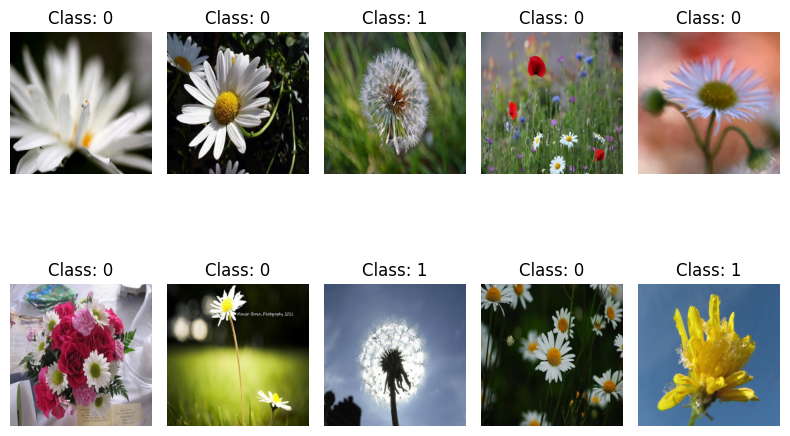

In [55]:
# Select 10 random samples from training set
indices = random.sample(range(len(train_dataset)), 10)

plt.figure(figsize = (8,6))
for i, index in enumerate(indices):
  image, label = train_dataset_raw[index]
  # if img is tensor
  if isinstance(image, torch.Tensor):
    img_np = image.permute(1,2,0).numpy()
  else:
    img_np = np.array(image)
  plt.subplot(2,5,i+1)
  plt.imshow(img_np)
  plt.title(f"Class: {label}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# Print dataset statistics
print(f'Train samples: {len(train_dataset)}')
print(f'Valid samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 1275
Valid samples: 364
Test samples: 182


In [57]:
# Function to plot class distribution
def plot_class(ax, img_dataset, title):
    idx_to_class = {0: 'daisy', 1: 'dandelion'}
    all_labels = []
    for index in range(len(img_dataset)):
        _, label = img_dataset[index]
        all_labels.append(label)

    labels_count = Counter(all_labels)
    labels = [0, 1]
    counts = [labels_count.get(idx, 0) for idx in labels]
    class_names = [idx_to_class[idx] for idx in labels]

    bars = ax.bar(class_names, counts, color='orange')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('# of Images', fontsize=12)
    ax.set_title(title, fontsize=14)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval),
                ha='center', va='bottom', fontsize=11)

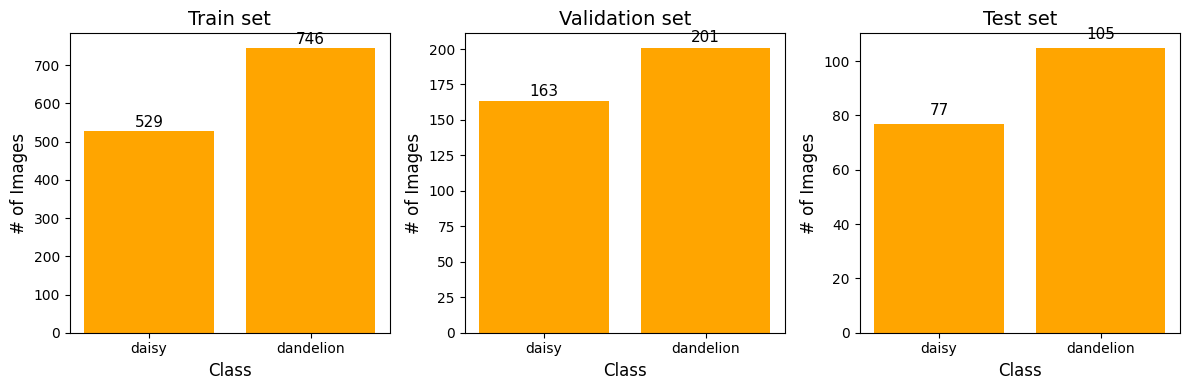

In [58]:
# Plot distributions for train/val/test
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_class(axes[0], train_dataset_raw, "Train set")
plot_class(axes[1], val_dataset_raw, "Validation set")
plot_class(axes[2], test_dataset_raw, "Test set")
plt.tight_layout()
plt.show()

# Training Utilities
Define early stopping, training and evaluation functions, and the main fit loop.


In [59]:
# Early stopping class to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=5, checkpoint_path="checkpoint.pt") -> None:
        self.patience = patience
        self.counter = 0
        self.best_f1 = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, f1_score: float, model=None, optimizer=None, epoch=None) -> None:
        if self.best_f1 is None or f1_score > self.best_f1:
            self.best_f1 = f1_score
            self.counter = 0
            if model is not None:  # Save only if model provided
                self._save_checkpoint(model, optimizer, epoch)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    # Save model checkpoint
    def _save_checkpoint(self, model, optimizer, epoch):
        state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
            'epoch': epoch,
            'best_score': self.best_f1
        }
        torch.save(state, self.checkpoint_path)

In [60]:
def evaluate(model, dataloader, criterion=None, return_preds=False):
    """
    Evaluate the model on a given dataset.

    Parameters
    ----------
    model : torch.nn.Module
        Model to evaluate.
    dataloader : torch.utils.data.DataLoader
        DataLoader for the evaluation data.
    criterion : torch.nn.Module, optional
        Loss function for evaluation; if None, loss is not computed.
    return_preds : bool, default False
        If True, returns also ground truth and predicted labels.

    Returns
    -------
    metrics : dict
        Dictionary with loss, accuracy, and macro F1-score.
    y_true, y_pred : list, optional
        Ground truth and predicted labels if return_preds is True.
    """
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if criterion is not None:
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)  # weighted sum

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    avg_loss = val_loss / total if criterion is not None else None
    accuracy = correct / total
    f1 = f1_score(y_true, y_pred, average='macro')

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "f1_macro": f1
    }

    if return_preds:
        return metrics, y_true, y_pred
    else:
        return metrics

In [61]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler=None):
    """
    Trains the model for a single epoch on the given data loader.

    Parameters
    ----------
    model : torch.nn.Module
        Model to be trained.
    dataloader : torch.utils.data.DataLoader
        DataLoader providing training data for the epoch.
    criterion : torch.nn.Module
        Loss function to compute the training loss.
    optimizer : torch.optim.Optimizer
        Optimizer to update model parameters.
    scheduler : torch.optim.lr_scheduler._LRScheduler, optional
        Learning rate scheduler to step after each epoch (default: None).

    Returns
    -------
    metrics : dict
        Dictionary containing average training loss and accuracy for the epoch.
    """
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = train_loss / total
    accuracy = correct / total

    return {"loss": avg_loss, "accuracy": accuracy}

In [62]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, early_stopping=None):
    """
    Trains and validates the model over multiple epochs, tracking learning progress and supporting backbone unfreezing and early stopping.

    Parameters
    ----------
    model : torch.nn.Module
        Neural network to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data.
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data.
    criterion : torch.nn.Module
        Loss function used for both training and validation.
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters.
    scheduler : torch.optim.lr_scheduler._LRScheduler, optional
        Learning rate scheduler to adjust the optimizer’s learning rate after each epoch.
    epochs : int
        Total number of epochs for training.
    early_stopping : callable or None, optional
        Early stopping callback; if provided, training stops when the given criteria are met.

    Returns
    -------
    history : dict
        Dictionary containing the history of training and validation metrics (loss, accuracy, F1) for each epoch.
    """
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "val_f1": []}

    for epoch in range(epochs):
        # After 5 epochs, unfreeze backbone and redefine optimizer/scheduler
        if epoch == 5:
            print("Unfreezing backbone for fine-tuning")
            unfreeze_backbone(model)
            optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - epoch)

        # training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler)

        # validation
        val_metrics = evaluate(model, val_loader, criterion)

        if scheduler is not None:
          scheduler.step()

        # log
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["train_acc"].append(train_metrics["accuracy"])
        history["val_acc"].append(val_metrics["accuracy"])
        history["val_f1"].append(val_metrics["f1_macro"])

        print(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train loss: {train_metrics['loss']:.4f}, acc: {train_metrics['accuracy']:.4f} "
            f"- Val loss: {val_metrics['loss']:.4f}, acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_macro']:.4f}"
        )

        # early stopping
        if early_stopping is not None:
            early_stopping(val_metrics["f1_macro"], model, optimizer, epoch)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    return history

# Training the Model
Train EfficientNet-B0 with class weights, AdamW optimizer, cosine annealing LR, and early stopping.


In [63]:
# Compute class weights to handle imbalance
labels = []

for _, label in train_dataset:
  labels.append(label)

# Count class frequencies
class_counts = Counter(labels)
num_samples = sum(class_counts.values())

# Compute weights: inverse frequency
class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([2.4102, 1.7091], device='cuda:0')


# Loading the Model

In [64]:
# Freeze backbone initially
freeze_backbone(model)

# Define loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
# Initialize early stopping and train
es = EarlyStopping(patience=5, checkpoint_path="checkpoint.pt")
history = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS, early_stopping=es)

In [66]:
with open("training_history.json", "w") as f:
    json.dump(history, f, indent=4)

# Training Curves
Visualize loss, accuracy, and F1 score evolution during training.


In [67]:
def load_history(path="training_history.json"):
    with open(path, "r") as f:
        history = json.load(f)
    return history

def load_test_results(path="test_results.json"):
    with open(path, "r") as f:
        results = json.load(f)
    return results

In [68]:
# Plot training curves
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    # F1-score
    plt.subplot(1,3,3)
    plt.plot(epochs, history["val_f1"], label="Val F1", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Macro")
    plt.title("Validation F1")
    plt.legend()

    plt.tight_layout()
    plt.show()

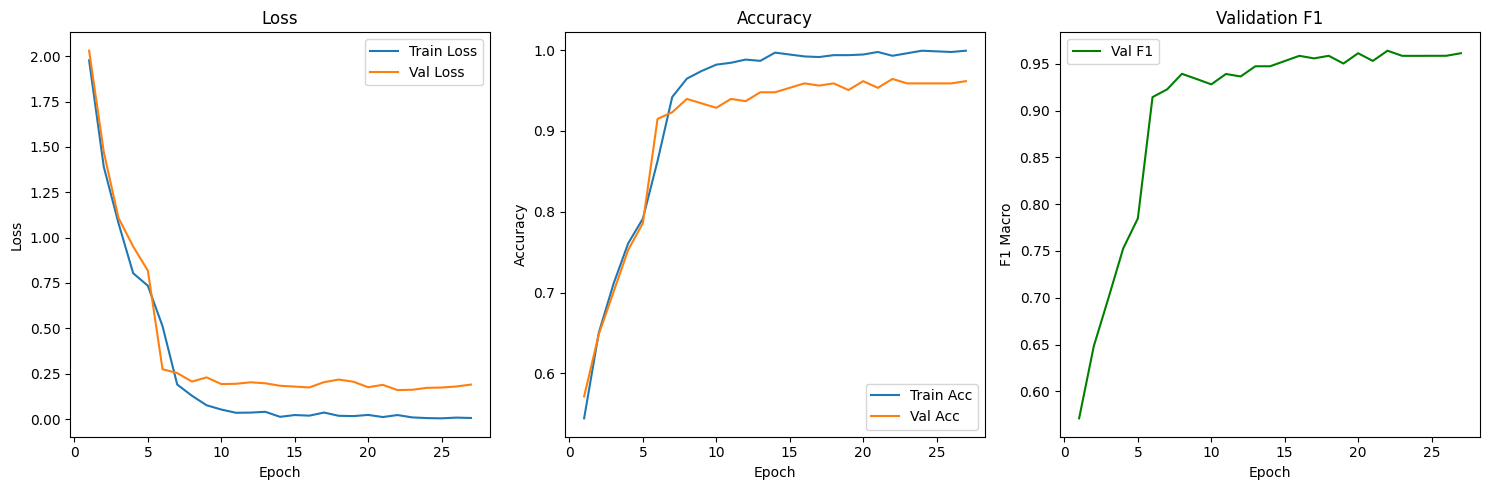

In [73]:
# Plotting curves
history = load_history()
plot_training_curves(history)

# Evaluation on Test Set
Load the best model checkpoint and evaluate it on the held-out test set.


In [74]:
# Test evaluation
checkpoint = torch.load("checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# using best model
test_metrics, y_true, y_pred = evaluate(model, test_loader, criterion=None, return_preds=True)

# Convert everything to JSON-serializable types
test_metrics_clean = {k: float(v) for k, v in test_metrics.items() if v is not None}

results = {
    "test_metrics": test_metrics_clean,
    "classification_report": classification_report(
        y_true, y_pred, target_names=["daisy", "dandelion"], output_dict=True
    ),
    "y_true": [int(x) for x in y_true],
    "y_pred": [int(x) for x in y_pred]
}

with open("test_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Test metrics:", test_metrics)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["daisy", "dandelion"]))


Test metrics: {'loss': None, 'accuracy': 0.9395604395604396, 'f1_macro': 0.9382003395585738}

Classification Report:
               precision    recall  f1-score   support

       daisy       0.92      0.94      0.93        77
   dandelion       0.95      0.94      0.95       105

    accuracy                           0.94       182
   macro avg       0.94      0.94      0.94       182
weighted avg       0.94      0.94      0.94       182



# Confusion Matrix
Visualize the confusion matrix for the test predictions.


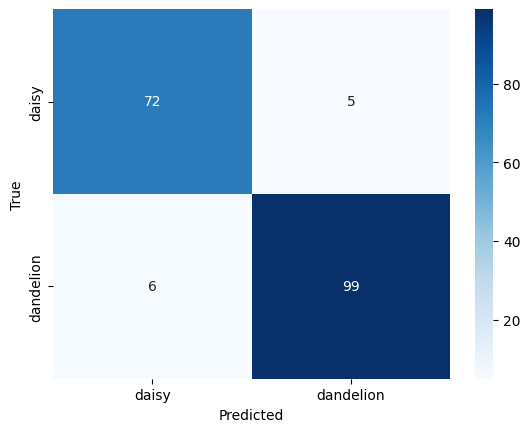

In [75]:
# Confusion matrix
results = load_test_results()
y_true, y_pred = results["y_true"], results["y_pred"]

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["daisy", "dandelion"],
            yticklabels=["daisy", "dandelion"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Showing errors

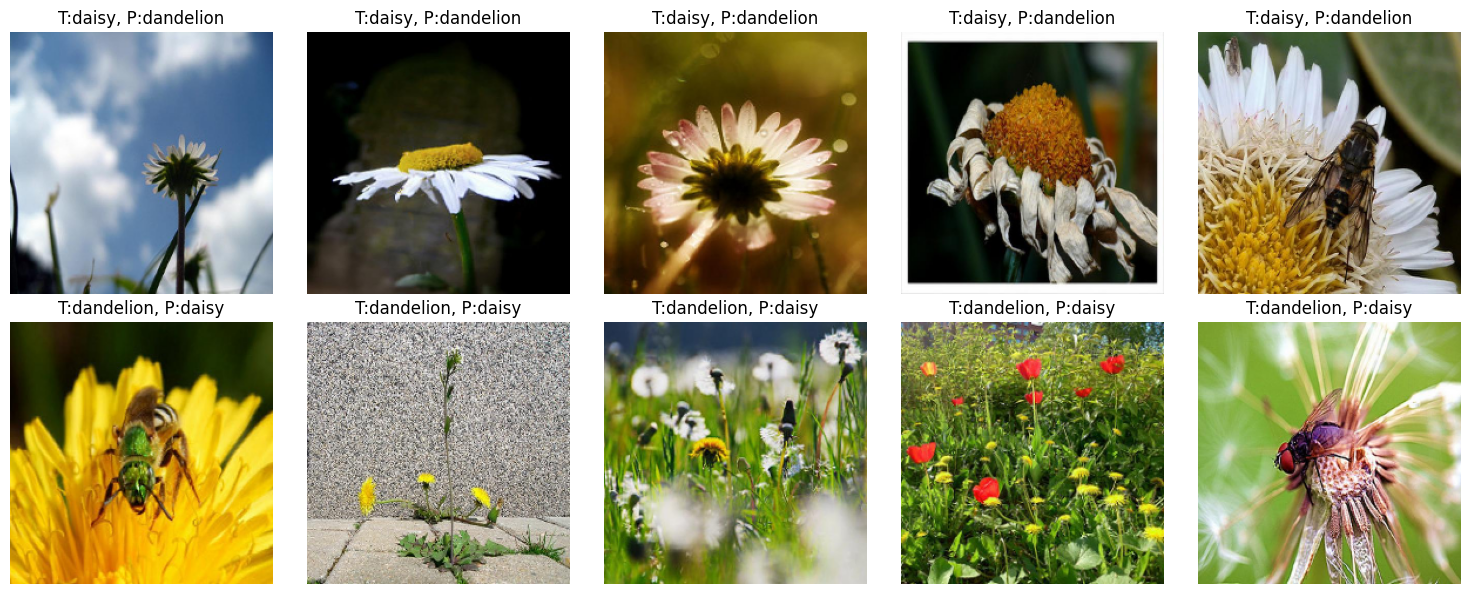

In [77]:
# Get indices of incorrect predictions
errors = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

# Dictionary to map class index to class name
idx_to_class = {0: "daisy", 1: "dandelion"}

# Select 5 misclassified examples for each true class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for row, true_class in enumerate([0, 1]):
    # Get first 5 errors where the true class matches the current row
    class_errors = [i for i in errors if y_true[i] == true_class][:5]
    for col, idx in enumerate(class_errors):
        # Load the unnormalized image from the test dataset
        img, _ = test_dataset_raw[idx]
        if isinstance(img, torch.Tensor):
            # Convert tensor image from (C, H, W) to (H, W, C) and to numpy array
            img = img.permute(1, 2, 0).numpy()
        # Show the image with the true (T) and predicted (P) classes
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"T:{idx_to_class[y_true[idx]]}, P:{idx_to_class[y_pred[idx]]}")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()


# General overview of the project and results

# Dataset

For this project I used the ‘flowers’ dataset. It consists of a collection of colored images about two categories of flowers (daisy and dandelion) used for a binary classification task. The dataset is split into 3 folders: Train, Validation and Test. It contains

```
Daisy (Margherita): 529 train images, 163 validation images, 77 test images.
Dandelion (Tarassaco): 746 train images, 201 validation images, 105 test images.
```
Note: during initial preprocessing, I found that some images in the provided folders were either invalid or corrupted. These files were filtered and removed to ensure the quality and consistency of the training and evaluation data. The actual number of samples for each class and split reflects only valid, readable images.

To increase robustness and prevent overfitting, data augmentation was applied using the Albumentations library. Images were normalized channel-wise with the mean and standard deviation of ImageNet (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]). This ensures input distributions are consistent with the EfficientNet pretraining setup, maximizing transfer learning effectiveness. Real-time transformations were applied, such as: rotation, shifting, color and light alterations, flipping, zooming, and shearing. On the validation and test sets, only resizing and normalization were applied to maintain evaluation integrity.



# Methodology

I chose `tf_efficientnet_b0.aa_in1k` from the timm library as the backbone for this task; based on the EfficientNet architecture, offers a highly efficient design that balances both depth and computational efficiency. Its use of compound scaling allows it to adapt well to different levels of model capacity, making it particularly effective for capturing intricate patterns and textures in flowers images. Compared to other architectures, it delivers a competitive performance while being less computationally intensive, making it well-suited for this task where both accuracy and efficiency are crucial.

# EfficientNet Architecture

`tf_efficientnet_b0` is a convolutional neural network designed to maximize computational efficiency while maintaining high performance in image classification tasks. Its architecture relies on a technique called compound scaling, which optimally balances the depth of the network, the width of the layers, and the input resolution. This approach results in a smaller, faster network that still captures complex features effectively.

The network consists of an initial conv_stem followed by a series of MBConv blocks (Mobile Inverted Bottleneck Convolutions), which are lightweight and efficient. These blocks use depthwise separable convolutions, significantly reducing computational costs compared to standard convolutions. The final output is processed through global average pooling and a fully connected classifier.

The model, pre-trained on ImageNet, has 1000 output classes and an input size of 224x224. Its energy-efficient design makes it particularly well-suited for applications requiring an optimal balance between speed and accuracy.

## Training Setup
For optimization I used AdamW, which separates weight decay from the gradient updates. In practice, this made training more stable and helped the model generalize better than with standard Adam.

I experimented with both StepLR and CosineAnnealingLR as learning rate schedulers. While StepLR introduces stepwise reductions in the rate, I found that the cosine-based schedule provided a smoother and more gradual decay. This allowed the model to adjust its weights in a steadier way, which reduced oscillations during training and ultimately led to better stability and accuracy.

A batch size of 32 was used. This value was chosen as it provides a good balance between computational efficiency and stable gradient estimation, compared to smaller or higher batch sizes tested.

## Experimental Setup
As said earlier, experiments were conducted using EfficientNet pretrained on ImageNet.

As a baseline, all convolutional layers were frozen for 5 epochs and only the final fully connected layer was trained, allowing the model to adapt ImageNet features to the flowers dataset.

Subsequently, fine-tuning was performed by gradually unfreezing deeper layers of the network, enabling the model to refine higher-level representations and better capture the specific characteristics of flowers images.

# Results

The learning curves shows a clear improvement in both training and validation accuracy as the training progresses. After an initial phase with the backbone frozen, unfreezing it at epoch 6 leads to a sharp increase in validation accuracy and F1 score, reaching over 94% accuracy and macro F1 in the later epochs. The curves indicate stable convergence, with validation loss and metrics stabilizing and only minor overfitting. Overall, the model achieves high and consistent performance, as confirmed by the final accuracy (~94%) and F1 macro score on the test set, demonstrating robust generalization.

# Confusion matrix

The confusion matrix for the test set shows that the model achieves a very high classification accuracy, with only a few misclassifications between the classes "daisy" and "dandelion." Both classes are predicted with similar precision and recall, confirming that the model is well balanced and generalizes effectively. The matrix indicates robust performance, as most samples are correctly identified, and there is no evident bias toward either class.

# Final overview:

In this project, we developed a binary classifier to distinguish between daisy and dandelion images using transfer learning with EfficientNet-B0. Careful dataset preparation, augmentation, and normalization helped secure robust input for the model. Starting with a frozen backbone and then fine-tuning all layers with AdamW and a cosine learning rate scheduler, the model quickly converged with stable training and validation curves. On the test set, the final model achieved approximately 94% accuracy and macro F1-score, with balanced performance for both classes as shown by the confusion matrix. Overall, the approach demonstrated strong generalization and reliability in flower recognition.

Among the test samples, the model’s misclassifications mostly occur in cases where flowers are partially occluded, shown from atypical angles, or surrounded by distracting backgrounds (e.g., insects on petals, cluttered scenes, or unusual perspectives). For example, daisies sometimes are wrongly predicted as dandelions and vice versa when their features (such as petal shape or flower head) appear ambiguous, wilted, or visually overlap with characteristics typical of the other class. These examples suggest that the model, while robust on clear samples, can struggle with challenging edge cases or images lacking distinctive visual cues, highlighting the value of further data augmentation or inclusion of more diverse examples in the training set to improve generalization to difficult scenarios.

---

## 📚 References & Resources

- [EfficientNet](https://docs.pytorch.org/vision/main/models/efficientnet.html)

- [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch?tab=readme-ov-file#about-efficientnet)

- [Transfer Learning using EfficientNet PyTorch](https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/)

- [Transfer Learning for Computer Vision Tutorial](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

- [CosineAnnealingLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

- [Albumentations](https://albumentations.ai/docs/)

- [Why is AdamW Often Superior to Adam with L2-Regularization in Practice?](https://www.geeksforgeeks.org/deep-learning/why-is-adamw-often-superior-to-adam-with-l2-regularization-in-practice/)

- [PyTorch Optimizer: AdamW and Adam with weight decay](https://stackoverflow.com/questions/64621585/pytorch-optimizer-adamw-and-adam-with-weight-decay)

- [Guide to Freezing Layers in AI Models](https://www.exxactcorp.com/blog/deep-learning/guide-to-freezing-layers-in-ai-models)

- [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

- Various YouTube videos

- ChatGPT – used for improving documentation clarity and polishing markdown sections
